# Insights into functions


Now that we are confident that the *proportion of mismatches* between two community metrics actually reflects their *collinearity* in our grasslands dataset, we can use our theory to gain new insights from the data. 

The goal of this chapter of the tutorial is to understand species contributions to community properties in a natural context. As species contributions to diversity metrics are well understood (diversity metrics are well-defined mathematical functions of species-abundance distributions), we'll focus on ecosystem functions. 

Let's start by setting up our environment and loading the data created in the first chapter of this tutorial.  

In [41]:
import pandas as pd                  # general data organisation         
import numpy as np                   # general work with matrices and vectors 
import matplotlib.pyplot as plt      # general plotting work
import networkx as nx                # for plotting a network
import matplotlib.colors as mcolors  # for color gradients

# for text formating in figures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",  
})

# loading the data and saving a colour
grasslands = pd.read_csv("data/grasslands.csv", index_col="Observation")
mismatch_matrix = pd.read_csv("data/mismatch_matrix.csv", index_col="Unnamed: 0")
grass_col = '#b89247'

## Similarity of functions

The first thing we can do is to use the mismatch matrices generated in *[Data preparation](data-preparation.ipynb)* as an adjacency matrix for a network that maps out the ecosystem functions based on their similarities. 

If we use a force-directed layout algorithm that pushes nodes away from each other based on the weight of their edges, then ecosystem functions with high proportions of mismatches (and therefore low collinearity) should be far apart in the 2D network. We'll use the Kamada-Kawai path-length cost-function to determine the layout of our network ([Tomihisa Kamada and Satoru Kawai, 1989](https://doi.org/10.1016/0020-0190(89)90102-6)). This force-directed algorithm treats the network as a system of springs and distance in the network should correspond to the proportion of mismatches. 

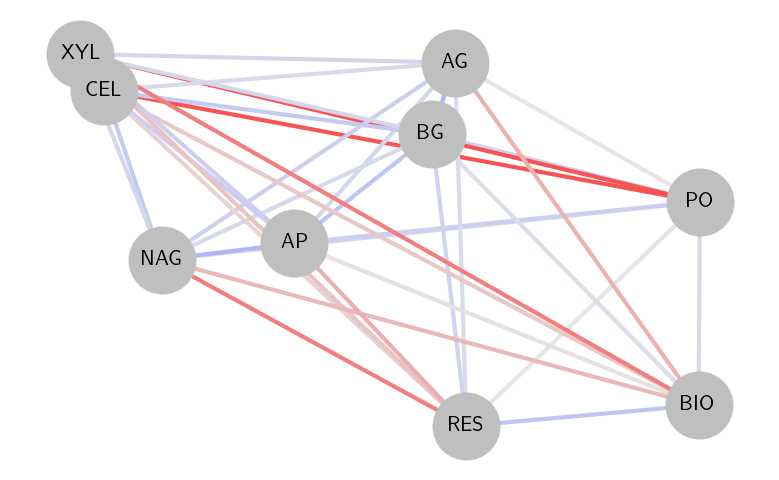

In [42]:
# convert pandas object to numpy array (making sure all entries are numeric)
mismatch_matrix = mismatch_matrix.apply(pd.to_numeric, errors='coerce')
adjacency_matrix = mismatch_matrix.values

# convert to a network object
G = nx.from_numpy_array(adjacency_matrix)

# set node names
node_names = dict(enumerate(mismatch_matrix.columns))
G = nx.relabel_nodes(G, node_names)

# shorten node labels for respiration and biomass 
old_node_names = list(G.nodes)
new_node_names = {'Respiration': 'RES', 'MicrobialBiomass': 'BIO'}
G = nx.relabel_nodes(G, new_node_names)

# set layout
pos = nx.kamada_kawai_layout(G)

# set edge weights
weights = nx.get_edge_attributes(G, 'weight')

# Map weights to colors in the colormap
blue = (0.6, 0.65, 1)
red = (1, 0.1, 0.1)
white = (0.9, 0.9, 0.9)
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [blue, white, red], N=256)
edge_colors = [cmap(weight) for weight in weights.values()]

# draw the network
plt.figure(num=None, figsize=(5, 3), dpi=150, facecolor='w', edgecolor='k')
nx.draw(G, pos, with_labels=True, 
        font_weight='bold', node_size=1000, 
        node_color=[[0.75, 0.75, 0.75]], 
        edge_color= edge_colors,
        font_size=10, 
        font_color='black',
        width=2);

As a reminder, the nine ecosystem functions from the mismatch matrix are: microbial respiration (*"RES"*) and microbial biomass (*"BIO"*), phenol oxidase (*"PO"*), α-1,4-glucosidase (*"AG"*), β-1,4-glucosidase (*"BG"*), cellobiohydrolase (*"CEL"*), β-1,4-xylosidase (*"XYL"*), N-acetyl-β-glucosaminidase (*"NAG"*), and phosphatase (*"AP"*). 

One of the first things to notice is that microbial respiration and microbial biomass, the only two "broad" ecosystem functions in this subset of the data, are right beside each other in the network. Even more reassuring is that the seven "narrow" ecosystem functions are grouped based on the nutrient cycles they are involved in. Nitrogen and phosphorus cycling enzymes (NAG and AP) are separated from the carbon cycling enzymes. Furthermore, the four hydrolytic carbon cycling enzymes (XYL, CEL, AG, and BG) are separated from the oxidative carbon cycling enzyme (PO). 

```{eval-rst}
.. note::

   If the network produced patterns of functional similarity that were unexpected based on knowledge gained in controlled lab studies, it could mean that the natural context (e.g., species interactions or environmentally-dependent per capita contributions) is playing a strong role in determining how species composition links to ecosystem functioning. 

.. include:: ./include-rst.rst
```

## Broadness of functions

We know that total biomass is the “broadest” ecosystem function; it’s vector of species per-capita contributions is, by definition, made up entirely of ones. We can therefore use total biomass as a baseline to quantify the broadness of other functions. The angle between biomass and other broad functions will be small so, over many perturbations with random effects, the proportion of mismatches will therefore be low. Narrower functions will have larger angles with biomass, which will result in higher proportions of mismatches. 

Working in reverse, we can use the proportion of mismatches between some function and total biomass (directly available from the data) to estimate the broadness of that function. For a fair estimate of broadness, the proportion of mismatches between the function and biomass should be quantified over a large pool of perturbations that collectively have random effects. Here, we do not consider perturbations of nutrients for ecosystem functions related to that nutrient – these perturbations have systematic effects rather than random effects – and we only consider cases where the proportion of mismatches between a function and biomass is based on at least twenty perturbations including at least five types of global change factors. 

First, let's recall the `mismatches` function from the first chapter of the tutorial and let's create another function called `broadness_func` that estimates the broadness of an ecosystem function based on its proportion of mismatches with total biomass. 

In [46]:
##### function to estimate the proportion of mismatches between two community properties #####
def mismatches(data, X, Y, min_obs):
    sub = data[[X, Y]].dropna()
    if X == Y:
        return 0
    if len(sub) < min_obs:
        return np.nan
    else:
        return np.sum(np.sign(sub[X]) != np.sign(sub[Y])) / len(sub)

##### function to estimate broadness of a function #####
def broadness_func(data, func):
    
    # subset just the pair of functions
    sub = data[["MicrobialBiomass", func, "GC"]].dropna()

    # option to exclude perturbations that are directly related to an ecosystem function (that have systematic effects)
    excluded = []
    if func in ["Nmin", "Nitrification", "Denitrification", "Nfixation", "Urease", "NAG", "LAP"]:
        excluded = ["N", "N_P"]
    elif func == "AP":
        excluded = ["P", "N_P"]
    sub = sub[~sub["GC"].isin(excluded)]
    
    # calculate mismatches
    mismatch = mismatches(sub, "MicrobialBiomass", func, 10)
    
    # count number of perturbations
    NP = len(sub)
    
    # count number of perturbation types 
    NPtype = len(sub["GC"].unique())
    
    new_values = pd.DataFrame({
        "func": [func],
        "NP": [NP],
        "NPtype": [NPtype],
        "mismatch": [mismatch]
    })
    
    return new_values

Next we'll loop over all the functions (except total biomass) to estimate their broadness. We'll only make estimates for the broadness of a function if the proportion of mismatches between that function and total biomass is based on many perturbations of different types (so that perturbations collectively have unbiased/random effects). 

In [44]:
# List of all functions (except MicrobialBiomass)
full_list = [
    "PO", "PER", "AG", "BG", "CEL", "XYL", "Invertase",
    "NAG", "LAP", "Urease", "AP",
    "Respiration", "Nmin",
    "Nitrification", "Denitrification", "Nfixation"
]

# empty dataframe to fill in 
broadness = pd.DataFrame()

# loop over forests and grasslands and across all functions to calculate broadness
for func in full_list:        
    new_values = broadness_func(grasslands, func)
    broadness = pd.concat([broadness, new_values], ignore_index=True)

# only take measures of broadness that are based on many perturbations of a range of types
broadness_data = broadness.dropna().loc[broadness["NP"] >= 20].loc[broadness["NPtype"] >= 5]
broadness_data["broadness"] = np.cos(np.pi * broadness_data["mismatch"].astype(float))**2
broadness_data["NP"] = broadness_data["NP"].astype(float)


We can now plot the estimated broadness of ecosystem functions.

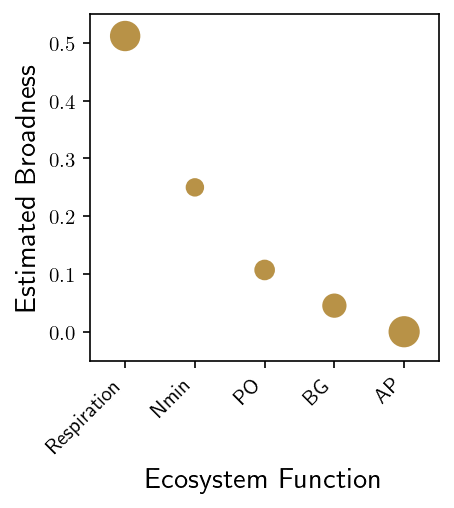

In [45]:
plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')

# sort the order from highest to lowest broadness 
order = ["Respiration", "Nmin", "PO", "BG", "AP"]
grass_broad = broadness_data.copy()
grass_broad['func'] = pd.Categorical(grass_broad['func'], categories=order, ordered=True)
grass_broad = grass_broad.sort_values(by='func')
grass_broad = grass_broad.reset_index(drop=True)

plt.scatter(grass_broad['func'], grass_broad['broadness'],
        s = grass_broad['NP']**1.25, c = grass_col)
plt.title('')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Ecosystem Function', labelpad=5, fontsize = 14)
plt.ylabel('Estimated Broadness', fontsize = 14)
plt.xlim(-0.5, 4.5)
plt.ylim(-0.05, 0.55)
plt.show()

There were enough data to estimate the broadness of five ecosystem functions: microbial respiration, net N mineralization rate, phenol oxidase (*"PO"*), β-1,4-xylosidase (*"XYL"*), and phosphatase (*"AP"*). 

As expected, microbial respiration was estimated to be the most broad of these five functions. The next function in terms of broadness was net N mineralization rate, which is presumably influenced by many different enzymes. Finally, three specific enzymes were estimated to be the narrowest of the five functions. These results suggest that more species contribute to the production of phenol oxidase (involved in the carbon cycle) than to the production of phosphatase (involved in the phosphorus cycle) in these grassland ecosystems. 

So far we've treated perturbations as tools to gain insights into species contributions to ecosystem functions. However, we can also use the mismatches between community properties in the observations of perturbations to gain useful information about the perturbations themselves. 